In [1]:
"""
File: Bi-LSTM.ipynb
Code to train and evaluate a bi-directional LSTM model on MIMIC-IV FHIR dataset.
"""

def Project():
    """
    __Objectives__
    0. Import data and tokenizer
    1. Train the tokenizer on all sequences of the dataset
    2. Tokenize different sequences and join them together
    3. Prepare actual labels for one, six, twelve month death after discharge
    4. Define the model architecture for bidrectional LSTM
    5. Train Bi-LSTM model and evaluate on test dataset
    >>> 6. Compare performance across new tasks to XGBoost
    """
    return ProjectObjectives.__doc__

In [2]:
import os; ROOT = '/fs01/home/afallah/odyssey/slurm'; os.chdir(ROOT)
import sys
import scipy, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
from scipy.sparse import csr_matrix, hstack, vstack, save_npz, load_npz

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import relu, leaky_relu, sigmoid
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn.utils.rnn import pack_padded_sequence

from models.cehr_bert.data import PretrainDataset, FinetuneDataset
from models.cehr_bert.model import BertPretrain
from models.cehr_bert.tokenizer import ConceptTokenizer
from models.cehr_bert.embeddings import Embeddings

from tqdm import tqdm
%matplotlib inline

DATA_ROOT = f'{ROOT}/data'
DATA_PATH = f'{DATA_ROOT}/patient_sequences.parquet'
SAMPLE_DATA_PATH = f'{DATA_ROOT}/CEHR-BERT_sample_patient_sequence.parquet'
FREQ_DF_PATH = f'{DATA_ROOT}/patient_feature_freq.csv'
FREQ_MATRIX_PATH = f'{DATA_ROOT}/patient_freq_matrix.npz'

2024-01-25 11:58:19.948892: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 11:58:20.005516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 11:58:20.005560: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 11:58:20.007522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 11:58:20.018439: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-25 11:58:20.019455: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
# save parameters and configurations
class config:
    seed = 23
    data_dir = DATA_ROOT
    test_size = 0.2
    batch_size = 64
    num_workers = 2
    vocab_size = None
    embedding_size = 128
    time_embeddings_size = 16
    max_len = 512
    device = torch.device('cuda')


def seed_all(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # pl.seed_everything(seed)


seed_all(config.seed)
print(f'Cuda: {torch.cuda.get_device_name(torch.cuda.current_device())}')

Cuda: Tesla T4


In [4]:
# Load data
data = pd.read_parquet(DATA_PATH)
data.rename(columns={'event_tokens': 'event_tokens_untruncated', 'event_tokens_updated': 'event_tokens'}, inplace=True)
data

,patient_id,num_visits,label,death_after_start,death_after_end,length,token_length,new_start,event_tokens_untruncated,event_tokens,age_tokens,time_tokens,visit_tokens,position_tokens
0,be7990af-3829-5df0-b552-c397a71d46fe,3,0,NaN,NaN,217,225,NaN,"[VS, 4443, 00338004304, 00006473900, 000935211...","[VS, 4443, 00338004304, 00006473900, 000935211...","[66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 66, 6...","[8000, 8000, 8000, 8000, 8000, 8000, 8000, 800...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,877d281b-676b-53ab-9911-1e4677989f6f,1,0,NaN,NaN,18,20,NaN,"[VS, 741, 00182864389, 00904585461, 0070345020...","[VS, 741, 00182864389, 00904585461, 0070345020...","[37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...","[5085, 5085, 5085, 5085, 5085, 5085, 5085, 508...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,65ae1ba2-dede-53a4-80be-3d0666b27e87,1,0,NaN,NaN,40,42,NaN,"[VS, 51248_2, 51736_2, 51244_3, 51222_4, 51737...","[VS, 51248_2, 51736_2, 51244_3, 51222_4, 51737...","[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 2...","[8787, 8787, 8787, 8787, 8787, 8787, 8787, 878...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,aa1446f6-dbc4-5734-9645-a1e01a7ba6f0,1,0,NaN,NaN,18,20,NaN,"[VS, 0689, 33332000801, 00056017075, 655970103...","[VS, 0689, 33332000801, 00056017075, 655970103...","[77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 77, 7...","[4853, 4853, 4853, 4853, 4853, 4853, 4853, 485...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,b3c303cc-df8c-5789-80f0-83f1c319b813,1,1,22.0,17.0,81,83,NaN,"[VS, 7935, 00338067104, 00054855324, 009045165...","[VS, 7935, 00338067104, 00054855324, 009045165...","[62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 6...","[6037, 6037, 6037, 6037, 6037, 6037, 6037, 603...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90273,88ae054e-0173-5049-b067-a67bad1aeee9,1,0,NaN,NaN,36,38,NaN,"[VS, 7931, 00075062041, 00023050601, 005363381...","[VS, 7931, 00075062041, 00023050601, 005363381...","[32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 3...","[8788, 8788, 8788, 8788, 8788, 8788, 8788, 878...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
90274,3b6ec88d-59a8-5833-8977-48e8b58211b1,1,0,NaN,NaN,17,19,NaN,"[VS, 00338067104, 51079045620, 66553000401, 00...","[VS, 00338067104, 51079045620, 66553000401, 00...","[68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 6...","[5353, 5353, 5353, 5353, 5353, 5353, 5353, 535...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
90275,b883470b-664e-5f0e-b38c-717cd5b07b84,1,1,3.0,0.0,152,154,NaN,"[VS, 5503, 00338004904, 00006494300, 001828447...","[VS, 5503, 00338004904, 00006494300, 001828447...","[81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 81, 8...","[7450, 7450, 7450, 7450, 7450, 7450, 7450, 745...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
90277,c946654b-2765-5dc1-8cd4-9865d3c84d30,2,0,NaN,NaN,46,51,NaN,"[VS, 51079088120, 51079088120, 68084025401, 00...","[VS, 51079088120, 51079088120, 68084025401, 00...","[45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 4...","[4850, 4850, 4850, 4850, 4850, 4850, 4850, 485...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [5]:
# Define custom labels, here death in 12 M
data['label'] = ((data['death_after_end'] > 0) & (data['death_after_end'] < 365)).astype(int)

In [6]:
# Fit tokenizer on .json vocab files
tokenizer = ConceptTokenizer(data_dir=config.data_dir)
tokenizer.fit_on_vocab()
config.vocab_size = tokenizer.get_vocab_size()
tokenizer

In [7]:
# Define dataset with token lengths
class DatasetWithTokenLength(Dataset):

    def __init__(self, tokenized_data, length_data):
        super(Dataset, self).__init__()

        self.tokenized_data = tokenized_data
        self.length_data = length_data
        assert len(tokenized_data) == len(length_data), "Datasets have different lengths"

        self.sorted_indices = sorted(range(len(length_data)), key=lambda x: length_data[x], reverse=True)
        # self.tokenized_data = [tokenized_data[i] for i in self.sorted_indices]
        # self.length_data = [min(length_data[i], ) for i in self.sorted_indices]

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, index):
        index = self.sorted_indices[index]
        return self.tokenized_data[index], min(config.max_len, self.length_data[index])


# Get training and test datasets
train_data, test_data = train_test_split(
    data,
    test_size=config.test_size,
    random_state=config.seed,
    stratify=data['label']
)

train_dataset = FinetuneDataset(
    data=train_data,
    tokenizer=tokenizer,
    max_len=config.max_len,
)

test_dataset = FinetuneDataset(
    data=test_data,
    tokenizer=tokenizer,
    max_len=config.max_len,
)

train_dataset_with_lengths = DatasetWithTokenLength(train_dataset, train_data['token_length'].values)
test_dataset_with_lengths = DatasetWithTokenLength(test_dataset, test_data['token_length'].values)

train_loader = DataLoader(
    train_dataset_with_lengths,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    shuffle=False,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset_with_lengths,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
    shuffle=False,
    pin_memory=True,
)

print("Data is ready to go!\n")

Data is ready to go!



In [8]:
# Define model architecture
class BiLSTMModel(nn.Module):

    def __init__(self, embedding_dim, hidden_size, num_layers, output_size, dropout_rate):
        super(BiLSTMModel, self).__init__()

        self.embeddings = Embeddings(
            vocab_size=config.vocab_size,
            embedding_size=config.embedding_size,
            time_embedding_size=config.time_embeddings_size,
            max_len=config.max_len)

        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True,
                            dropout=dropout_rate)

        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_size * 2, output_size)

    def forward(self, inputs, lengths):
        embed = self.embeddings(*inputs)
        packed_embed = pack_padded_sequence(embed, lengths.cpu(), batch_first=True)

        lstm_out, (hidden_state, cell_state) = self.lstm(packed_embed)
        # output = lstm_out[:, -1, :]
        output = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)

        output = self.dropout(self.batch_norm(output))
        output = self.linear(output)
        return output

    @staticmethod
    def get_inputs_labels(sequences):
        labels = sequences['labels'].view(-1, 1).to(config.device)
        inputs = sequences['concept_ids'].to(config.device), \
            sequences['time_stamps'].to(config.device), \
            sequences['ages'].to(config.device), \
            sequences['visit_orders'].to(config.device), \
            sequences['visit_segments'].to(config.device)

        return inputs, labels.float()

    @staticmethod
    def get_balanced_accuracy(outputs, labels):
        predictions = torch.round(sigmoid(outputs))
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        return balanced_accuracy_score(labels, predictions)

In [9]:
# Set hyperparameters for Bi-LSTM model adn training loop
input_size = config.embedding_size          # embedding_dim
hidden_size = config.embedding_size // 2    # output hidden size
num_layers = 5                              # number of LSTM layers
output_size = 1                             # Binary classification, so output size is 1
dropout_rate = 0.2                          # Dropout rate for regularization

epochs = 6
learning_rate = 0.001

In [ ]:
# Training Loop
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate).to(config.device)
loss_fcn = nn.BCEWithLogitsLoss(weight=torch.tensor([0.1, 0.9]))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.7, verbose=True)

for epoch in range(epochs):
    train_total_loss = 0
    train_accuracy = 0
    test_accuracy = 0

    model.train()
    for batch_no, (sequences, lengths) in tqdm(enumerate(train_loader), file=sys.stdout,
                                               total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}',
                                               unit=' batch'):
        inputs, labels = model.get_inputs_labels(sequences)
        outputs = model(inputs, lengths)
        loss = loss_fcn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        # tqdm.write(f'Batch Loss: {loss.item():.4f}', file=sys.stdout, end='\r')
        # print(f'\nBatch Loss: {loss.item():.4f}', end='\r')

    model.eval()
    with torch.no_grad():
        for batch_no, (sequences, lengths) in tqdm(enumerate(train_loader), file=sys.stdout,
                                                   total=len(train_loader),
                                                   desc=f'Train Evaluation {epoch + 1}/{epochs}',
                                                   unit=' batch'):
            inputs, labels = model.get_inputs_labels(sequences)
            outputs = model(inputs, lengths)
            train_accuracy += model.get_balanced_accuracy(outputs, labels)


        for batch_no, (sequences, lengths) in tqdm(enumerate(test_loader), file=sys.stdout,
                                                   total=len(test_loader), desc=f'Test Evaluation {epoch + 1}/{epochs}',
                                                   unit=' batch'):
            inputs, labels = model.get_inputs_labels(sequences)
            outputs = model(inputs, lengths)
            test_accuracy += model.get_balanced_accuracy(outputs, labels)

    print(
        f'\nEpoch {epoch + 1}/{epochs}  |  '
        f'Average Train Loss: {train_total_loss / len(train_loader):.5f}  |  '
        f'Train Accuracy: {train_accuracy / len(train_loader):.5f}  |  '
        f'Test Accuracy: {test_accuracy / len(test_loader):.5f}\n\n')
    scheduler.step()

# torch.save(model, 'LSTM_V2.pt')

In [10]:
state_dict = torch.load('/fs01/home/afallah/odyssey/slurm/LSTM_V2.pt').state_dict()
model = BiLSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate).to(config.device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [11]:
y_train_pred = np.array([]); y_train_labels = np.array([])
y_test_pred = np.array([]); y_test_labels = np.array([])


model.eval()
with torch.no_grad():
    for batch_no, (sequences, lengths) in tqdm(enumerate(train_loader), file=sys.stdout,
                                               total=len(train_loader),
                                               desc=f'Train Evaluation',
                                               unit=' batch'):
        inputs, labels = model.get_inputs_labels(sequences)
        outputs = model(inputs, lengths)

        predictions = torch.round(sigmoid(outputs))
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        y_train_pred = np.append(y_train_pred, predictions)
        y_train_labels = np.append(y_train_labels, labels)


    for batch_no, (sequences, lengths) in tqdm(enumerate(test_loader), file=sys.stdout,
                                               total=len(test_loader), desc=f'Test Evaluation',
                                               unit=' batch'):
        inputs, labels = model.get_inputs_labels(sequences)
        outputs = model(inputs, lengths)

        predictions = torch.round(sigmoid(outputs))
        predictions = predictions.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()

        y_test_pred = np.append(y_test_pred, predictions)
        y_test_labels = np.append(y_test_labels, labels)

Test Evaluation: 100%|██████████| 272/272 [02:01<00:00,  2.24 batch/s]


In [12]:
all_data_pred = np.append(y_train_pred, y_test_pred)
all_data_labels = np.append(y_train_labels, y_test_labels)

Balanced Accuracy
Train: 0.82788  |  Test: 0.81664  |  All Data: 0.82564

F1 Score
Train: 0.45104  |  Test: 0.44044  |  All Data: 0.44892

Precision
Train: 0.29784  |  Test: 0.29046  |  All Data: 0.29636

Recall
Train: 0.92878  |  Test: 0.91067  |  All Data: 0.92516

AUROC
Train: 0.82788  |  Test: 0.81664  |  All Data: 0.82564

AUC-PR
Train: 0.61726  |  Test: 0.60552  |  All Data: 0.61491

Average Precision Score
Train: 0.28453  |  Test: 0.27442  |  All Data: 0.28248



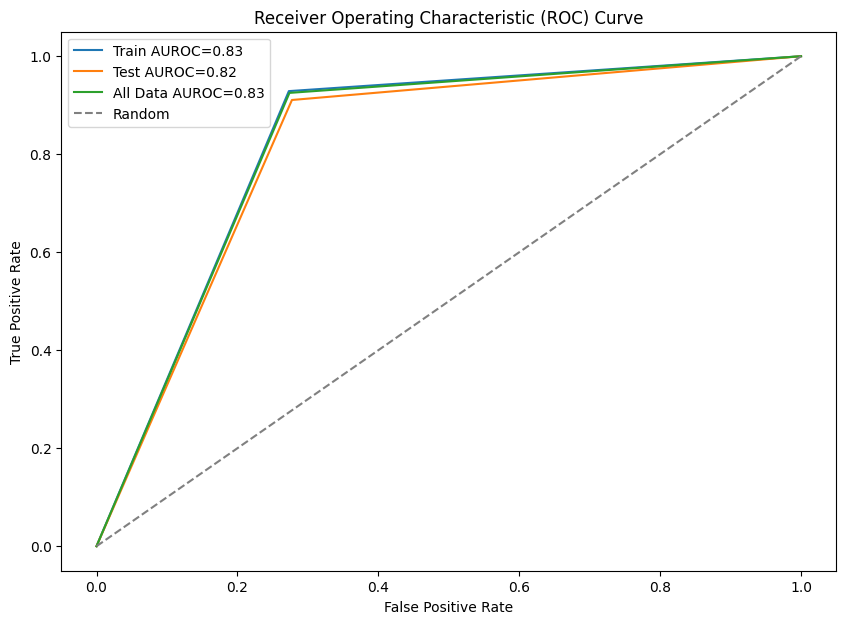

In [13]:
### ASSESS MODEL PERFORMANCE ###

# Balanced Accuracy
y_train_accuracy = balanced_accuracy_score(y_train_labels, y_train_pred)
y_test_accuracy = balanced_accuracy_score(y_test_labels, y_test_pred)
all_data_accuracy = balanced_accuracy_score(all_data_labels, all_data_pred)

# F1 Score
y_train_f1 = f1_score(y_train_labels, y_train_pred)
y_test_f1 = f1_score(y_test_labels, y_test_pred)
all_data_f1 = f1_score(all_data_labels, all_data_pred)

# Precision
y_train_precision = precision_score(y_train_labels, y_train_pred)
y_test_precision = precision_score(y_test_labels, y_test_pred)
all_data_precision = precision_score(all_data_labels, all_data_pred)

# Recall
y_train_recall = recall_score(y_train_labels, y_train_pred)
y_test_recall = recall_score(y_test_labels, y_test_pred)
all_data_recall = recall_score(all_data_labels, all_data_pred)

# AUROC
y_train_auroc = roc_auc_score(y_train_labels, y_train_pred)
y_test_auroc = roc_auc_score(y_test_labels, y_test_pred)
all_data_auroc = roc_auc_score(all_data_labels, all_data_pred)

# AUC-PR (Area Under the Precision-Recall Curve)
y_train_p, y_train_r, _ = precision_recall_curve(y_train_labels, y_train_pred)
y_test_p, y_test_r, _ = precision_recall_curve(y_test_labels, y_test_pred)
all_data_p, all_data_r, _ = precision_recall_curve(all_data_labels, all_data_pred)

y_train_auc_pr = auc(y_train_r, y_train_p)
y_test_auc_pr = auc(y_test_r, y_test_p)
all_data_auc_pr = auc(all_data_r, all_data_p)

# Average Precision Score (APS)
y_train_aps = average_precision_score(y_train_labels, y_train_pred)
y_test_aps = average_precision_score(y_test_labels, y_test_pred)
all_data_aps = average_precision_score(all_data_labels, all_data_pred)

# Print Metrics
print(f"Balanced Accuracy\nTrain: {y_train_accuracy:.5f}  |  Test: {y_test_accuracy:.5f}  |  All Data: {all_data_accuracy:.5f}\n")
print(f"F1 Score\nTrain: {y_train_f1:.5f}  |  Test: {y_test_f1:.5f}  |  All Data: {all_data_f1:.5f}\n")
print(f"Precision\nTrain: {y_train_precision:.5f}  |  Test: {y_test_precision:.5f}  |  All Data: {all_data_precision:.5f}\n")
print(f"Recall\nTrain: {y_train_recall:.5f}  |  Test: {y_test_recall:.5f}  |  All Data: {all_data_recall:.5f}\n")
print(f"AUROC\nTrain: {y_train_auroc:.5f}  |  Test: {y_test_auroc:.5f}  |  All Data: {all_data_auroc:.5f}\n")
print(f"AUC-PR\nTrain: {y_train_auc_pr:.5f}  |  Test: {y_test_auc_pr:.5f}  |  All Data: {all_data_auc_pr:.5f}\n")
print(f"Average Precision Score\nTrain: {y_train_aps:.5f}  |  Test: {y_test_aps:.5f}  |  All Data: {all_data_aps:.5f}\n")

# Plot ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train_labels, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test_labels, y_test_pred)
fpr_all_data, tpr_all_data, _ = roc_curve(all_data_labels, all_data_pred)

# Plot Information
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, label=f'Train AUROC={y_train_auroc:.2f}')
plt.plot(fpr_test, tpr_test, label=f'Test AUROC={y_test_auroc:.2f}')
plt.plot(fpr_all_data, tpr_all_data, label=f'All Data AUROC={all_data_auroc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()